1. Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification

import numpy as np

In [2]:
classification_data, classification_labels = make_classification(n_samples=100,
                                                                 n_features=2, n_informative=2,
                                                                 n_classes=2, n_redundant=0,
                                                                 n_clusters_per_class=1, random_state=23)

In [3]:
np.random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0] # размер совпадает с исходной выборкой
    bootstrap = []

    for i in range(N):

        sample_index = np.random.randint(0, n_samples, size=n_samples)
        b_data = data[sample_index]
        b_labels = labels[sample_index]

        bootstrap.append((b_data, b_labels))

    return bootstrap

In [4]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = list(range(len_sample))

    len_subsample = int(np.sqrt(len_sample))

    subsample = np.random.choice(sample_indexes, size=len_subsample, replace=False)

    return subsample

In [5]:
# Реализуем класс узла

class Node:

    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [6]:
# И класс терминального узла (листа)

class Leaf:

    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()

    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его
        prediction = max(classes, key=classes.get)
        return prediction

In [7]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1

    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2

    return impurity

In [8]:
# Расчет прироста

def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [9]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):

    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)

    true_data = data[left]
    false_data = data[right]

    true_labels = labels[left]
    false_labels = labels[right]

    return true_data, false_data, true_labels, false_labels

In [10]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):

    #  обозначим минимальное количество объектов в узле
    min_leaf_samples = 5

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None

    n_features = data.shape[1]

    feature_subsample_indices = get_subsample(n_features) # выбираем случайные признаки

    for index in feature_subsample_indices:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])

        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
#             if len(true_data) < min_leaf_samples or len(false_data) < min_leaf_samples:
#                 continue

            current_gain = gain(true_labels, false_labels, root_gini)

            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [11]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [12]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)

    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))

    return forest

In [13]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [14]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):

    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [15]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
#     print(predictions)

    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
#     print(predictions_per_object)

    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))

    return voted_predictions

In [16]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data,
                                                                    classification_labels,
                                                                    test_size=0.3,
                                                                    random_state=42)

In [17]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

Строим леса, согласно задания.

In [18]:
forest_1 = random_forest(train_data, train_labels, 1)
train_answers_1 = tree_vote(forest_1, train_data)
test_answers_1 = tree_vote(forest_1, test_data)

forest_3 = random_forest(train_data, train_labels, 3)
train_answers_3 = tree_vote(forest_3, train_data)
test_answers_3 = tree_vote(forest_3, test_data)

forest_10 = random_forest(train_data, train_labels, 10)
train_answers_10 = tree_vote(forest_10, train_data)
test_answers_10 = tree_vote(forest_10, test_data)

forest_50 = random_forest(train_data, train_labels, 50)
train_answers_50 = tree_vote(forest_50, train_data)
test_answers_50 = tree_vote(forest_50, test_data)

In [19]:
# Точность на обучающей выборке
train_accuracy_1 = accuracy_metric(train_labels, train_answers_1)
train_accuracy_3 = accuracy_metric(train_labels, train_answers_3)
train_accuracy_10 = accuracy_metric(train_labels, train_answers_10)
train_accuracy_50 = accuracy_metric(train_labels, train_answers_50)


# Точность на тестовой выборке
test_accuracy_1 = accuracy_metric(test_labels, test_answers_1)
test_accuracy_3 = accuracy_metric(test_labels, test_answers_3)
test_accuracy_10 = accuracy_metric(test_labels, test_answers_10)
test_accuracy_50 = accuracy_metric(test_labels, test_answers_50)

print(f'1 дерево: \nТочность на тренировачной выборке: {train_accuracy_1:.3f}\nТочность на тестовоой выборке: {test_accuracy_1:.3f}\n\n')
print(f'3 дерева: \nТочность на тренировачной выборке: {train_accuracy_3:.3f}\nТочность на тестовоой выборке: {test_accuracy_3:.3f}\n\n')
print(f'10 деревьев: \nТочность на тренировачной выборке: {train_accuracy_10:.3f}\nТочность на тестовоой выборке: {test_accuracy_10:.3f}\n\n')
print(f'50 деревьев: \nТочность на тренировачной выборке: {train_accuracy_50:.3f}\nТочность на тестовоой выборке: {test_accuracy_50:.3f}\n\n')

1 дерево: 
Точность на тренировачной выборке: 92.857
Точность на тестовоой выборке: 86.667


3 дерева: 
Точность на тренировачной выборке: 98.571
Точность на тестовоой выборке: 93.333


10 деревьев: 
Точность на тренировачной выборке: 97.143
Точность на тестовоой выборке: 93.333


50 деревьев: 
Точность на тренировачной выборке: 100.000
Точность на тестовоой выборке: 93.333




In [20]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_data, test_data, train_accuracy, test_accuracy, forest):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors, shading="auto")
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

<ipython-input-20-be572d99037a>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


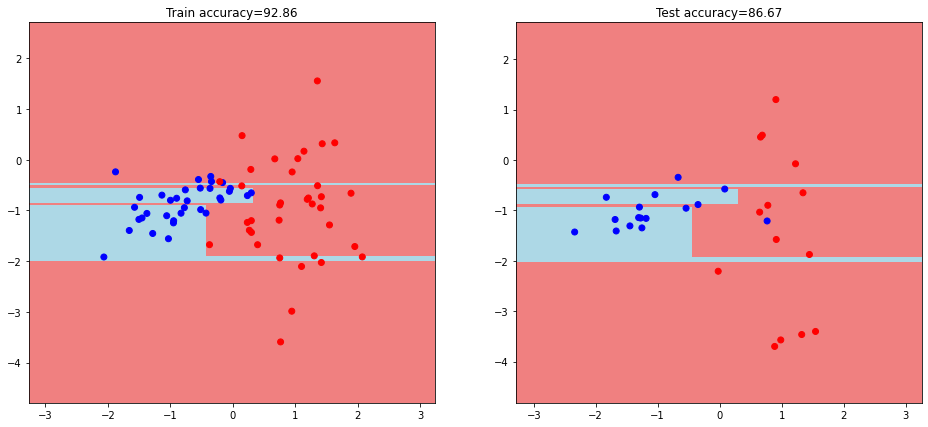

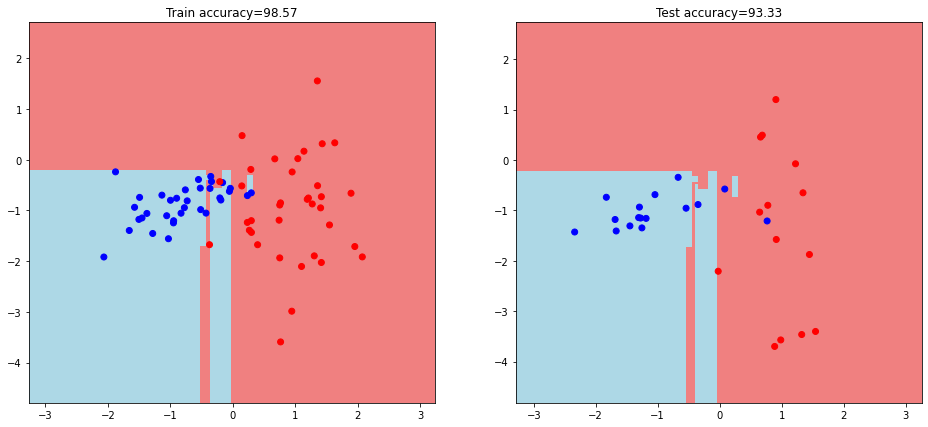

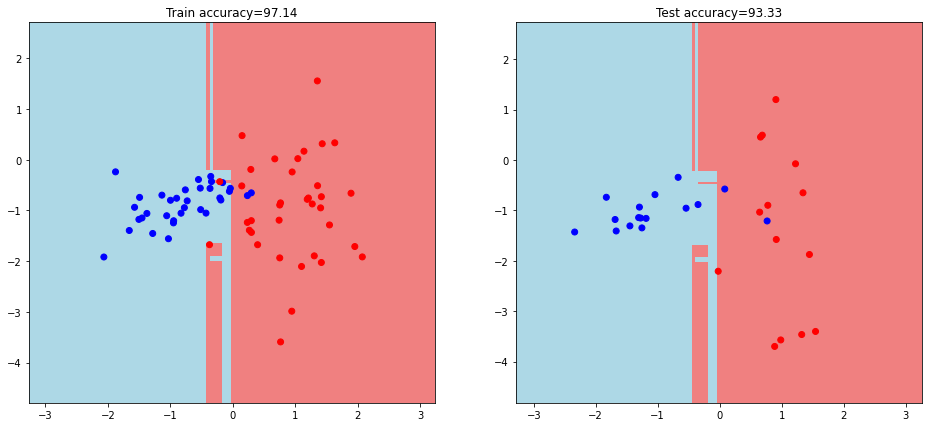

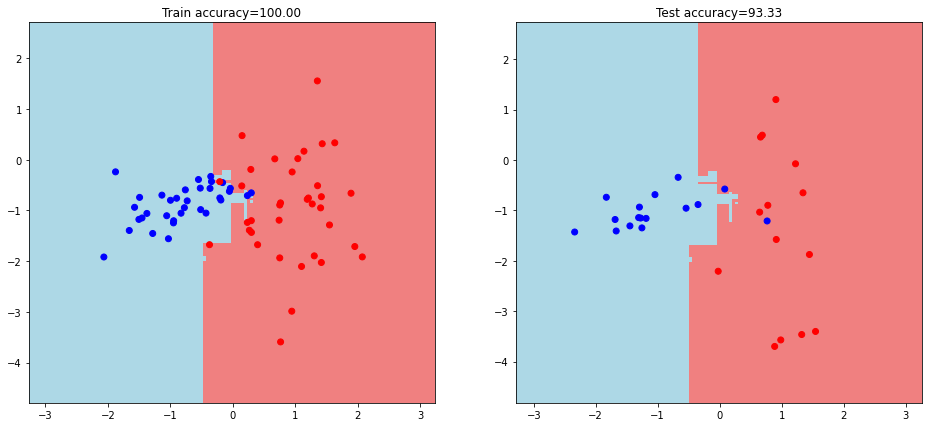

In [21]:
visualize(train_data, test_data, train_accuracy_1, test_accuracy_1, forest_1)
visualize(train_data, test_data, train_accuracy_3, test_accuracy_3, forest_3)
visualize(train_data, test_data, train_accuracy_10, test_accuracy_10, forest_10)
visualize(train_data, test_data, train_accuracy_50, test_accuracy_50, forest_50)


2. Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

На таком небольшом количестве данных сложно делать выводы. С ростом количества деревьев растет точность модели на тренировачных данных. Однако это не так для тестовых данных, где точность не менялась при выыращивании леса в 3, 10 или 50 деревьев. Что свидеьельствует о переобучении модели. Для этого набор данных оптимальным, на мой взгляд, будет случайный лес из 3 деревьев.

